# Libs:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import optuna
from optuna.visualization.matplotlib import plot_param_importances

import xgboost

import pickle

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/flyandlure/datasets/master/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Engineer features

## One-Hot encode the data

In [4]:
df['ocean_proximity'].value_counts().reset_index()

,ocean_proximity,count
0,<1H OCEAN,9136
1,INLAND,6551
2,NEAR OCEAN,2658
3,NEAR BAY,2290
4,ISLAND,5


In [5]:
df['ocean_proximity'] = df['ocean_proximity'].str.lower().replace('[^0-9a-zA-Z]+', '_', regex=True)

In [6]:
df['ocean_proximity'].value_counts()

ocean_proximity
_1h_ocean     9136
inland        6551
near_ocean    2658
near_bay      2290
island           5
Name: count, dtype: int64

In [7]:
encodings = pd.get_dummies(df['ocean_proximity'], prefix='proximity')

In [8]:
df = pd.concat([df, encodings], axis=1)

In [9]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,proximity__1h_ocean,proximity_inland,proximity_island,proximity_near_bay,proximity_near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay,False,False,False,True,False


## Impute missing values

In [10]:
df.isna().mean().sort_values(ascending=False)

total_bedrooms          0.010029
longitude               0.000000
latitude                0.000000
housing_median_age      0.000000
total_rooms             0.000000
population              0.000000
households              0.000000
median_income           0.000000
median_house_value      0.000000
ocean_proximity         0.000000
proximity__1h_ocean     0.000000
proximity_inland        0.000000
proximity_island        0.000000
proximity_near_bay      0.000000
proximity_near_ocean    0.000000
dtype: float64

In [11]:
df = df.fillna(0)

In [12]:
df.isna().mean().sort_values(ascending=False)

longitude               0.0
latitude                0.0
housing_median_age      0.0
total_rooms             0.0
total_bedrooms          0.0
population              0.0
households              0.0
median_income           0.0
median_house_value      0.0
ocean_proximity         0.0
proximity__1h_ocean     0.0
proximity_inland        0.0
proximity_island        0.0
proximity_near_bay      0.0
proximity_near_ocean    0.0
dtype: float64

## Define the target variable

In [13]:
X = df.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = df['median_house_value']

## Split the data into training and test sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42)

## Scale the data

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
X_train

array([[ 0.78093406, -0.80568191,  0.50935748, ..., -0.01664126,
        -0.35549129, -0.37688739],
       [ 1.24526986, -1.33947268, -0.67987313, ..., -0.01664126,
        -0.35549129,  2.65331242],
       [-0.27755183, -0.49664515, -0.36274497, ..., -0.01664126,
        -0.35549129,  2.65331242],
       ...,
       [ 0.60119118, -0.75885816,  0.58863952, ..., -0.01664126,
        -0.35549129, -0.37688739],
       [-1.18625198,  0.90338501, -1.07628333, ..., -0.01664126,
        -0.35549129, -0.37688739],
       [-1.41592345,  0.99235014,  1.85715216, ..., -0.01664126,
         2.81300847, -0.37688739]])

# Train the model

In [17]:
model = xgboost.XGBRegressor()

In [18]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
%%time

y_pred = model.predict(X_test)

CPU times: user 1.14 s, sys: 11.9 ms, total: 1.15 s
Wall time: 216 ms


In [20]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("R^2 : ", r2_score(y_test, y_pred))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE : 0.18250912047889994
MAE : 31948.583973650475
R^2 :  0.8230168027376557
RMSE: 48197.25560817335


# Optuna to tune the XGBRegressor model

In [21]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [23]:
study = optuna.create_study(direction='minimize', study_name='regression')

In [24]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 10, 'learning_rate': 0.012963200238728382, 'n_estimators': 953, 'min_child_weight': 1, 'gamma': 0.40230111543292824, 'subsample': 0.7671743682024627, 'colsample_bytree': 0.7566583682428192, 'reg_alpha': 0.6517670763960355, 'reg_lambda': 0.15030401758226364, 'random_state': 127}


In [26]:
print('Best value', study.best_value)

Best value 2037411433.3922253


In [27]:
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=87, state=TrialState.COMPLETE, values=[2037411433.3922253], datetime_start=datetime.datetime(2023, 11, 29, 17, 40, 35, 178751), datetime_complete=datetime.datetime(2023, 11, 29, 17, 40, 46, 819507), params={'max_depth': 10, 'learning_rate': 0.012963200238728382, 'n_estimators': 953, 'min_child_weight': 1, 'gamma': 0.40230111543292824, 'subsample': 0.7671743682024627, 'colsample_bytree': 0.7566583682428192, 'reg_alpha': 0.6517670763960355, 'reg_lambda': 0.15030401758226364, 'random_state': 127}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, lo

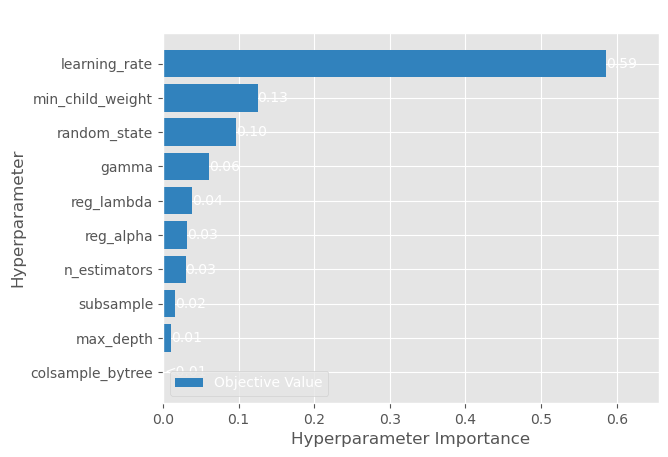

In [28]:
plot_param_importances(study);

## Use the optimal hyperparameters to train the model

In [29]:
model = xgboost.XGBRegressor(**study.best_params)

In [30]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7566583682428192, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.40230111543292824,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012963200238728382,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=953, n_jobs=None,
             num_parallel_tree=None, random_state=127, ...)

In [31]:
%%time
y_pred = model.predict(X_test)

CPU times: user 1.07 s, sys: 3.9 ms, total: 1.07 s
Wall time: 200 ms


In [67]:
print("MAPE :", mean_absolute_percentage_error(y_test,y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("R^2 : ", r2_score(y_test, y_pred))    
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

MAPE : 0.17176059596681612
MAE : 29746.86925733305
R^2 :  0.8451173292179802
RMSE: 45087.66099574598


# Save the model using Pickle

In [68]:
filename = "xgbregressor.pkl"

In [69]:
pickle.dump(model, open(filename, "wb"))